# Network analsys for SIR model

## Libraries

In [16]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
seed = np.random.seed(2137)

## Parameters and data

In [22]:

#? Probability of disease transmission
p:float = 0.05  
#? Minimum amount of time a node remains infected
tI:float = 3    
#? Probability of recovery
q:float = 0.1   
#? Initial number of infected individuals
i0:float = 5
DATA_PATH: Path = Path('../data/bn-mouse-kasthuri_graph_v4.edges')
print(f"Using dataset from {DATA_PATH.absolute()}")
# Create a small graph for testing
G = nx.read_edgelist(path=DATA_PATH, create_using=nx.Graph(), nodetype=int)
print('#nodes:', len(G.nodes()), 'and', '#edges:', len(G.edges()))


Using dataset from c:\Users\szink\Desktop\programming\NetworkAnalysis\assignment2\src\..\data\bn-mouse-kasthuri_graph_v4.edges
#nodes: 1029 and #edges: 1559


In [24]:
# Fix the position
pos = nx.spring_layout(G, seed=seed)
shells = [[0], [1, 2, 3]]
pos = nx.shell_layout(G, shells)
# Initialize all nodes to susceptible
nx.set_node_attributes(G, 'S', 'state')

## Visualization function

NetworkXError: Node 9 has no position.

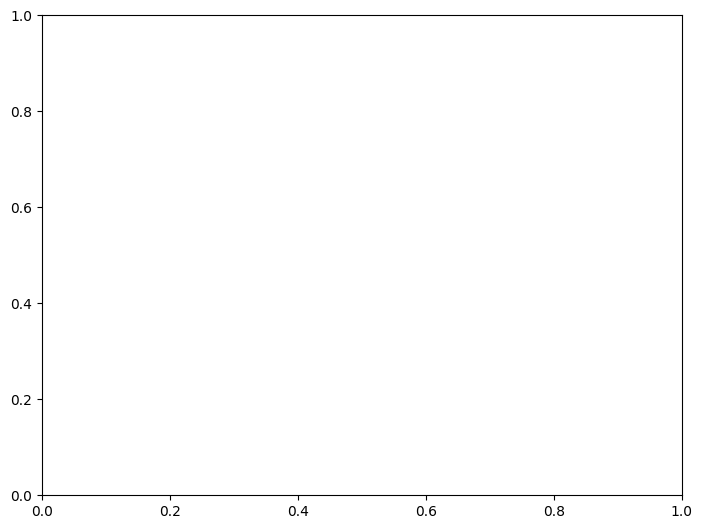

In [25]:

def draw_graph(G, pos):
    state_color = {'S': 'blue', 'I': 'red', 'R': 'green'}
    colors = [state_color[G.nodes[n]['state']] for n in G.nodes]
    nx.draw(G, pos, node_color=colors, node_size=10, edge_color='gray')
    plt.show()

draw_graph(G, pos)

## Starting infection

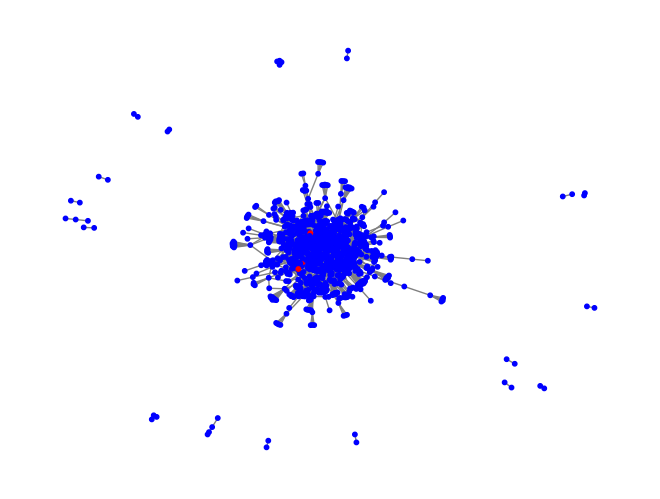

In [ ]:
infected_nodes = np.random.choice(a=list(G.nodes()),size= i0, )
for node in infected_nodes:
    G.nodes[node]['state'] = 'I'

draw_graph(G, pos)